Credit: Code adapted from Sklearn

In [1]:
%matplotlib inline


# Comparing different clustering algorithms on toy datasets


This example shows characteristics of different
clustering algorithms on datasets that are "interesting"
but still in 2D. With the exception of the last dataset,
the parameters of each of these dataset-algorithm pairs
has been tuned to produce good clustering results. Some
algorithms are more sensitive to parameter values than
others.

The last dataset is an example of a 'null' situation for
clustering: the data is homogeneous, and there is no good
clustering. For this example, the null dataset uses the
same parameters as the dataset in the row above it, which
represents a mismatch in the parameter values and the
data structure.

While these examples give some intuition about the
algorithms, this intuition might not apply to very high
dimensional data.



In [51]:
# ============
# Imports
# ============
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from sklearn.manifold import SpectralEmbedding

Automatically created module for IPython interactive environment


In [52]:
np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up default cluster parameters
# ============

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

dataset_list = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

# ============
# Normalize and print each dataset
# ============

for i_dataset, (dataset, algo_params) in enumerate(dataset_list):

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    mat = []
    for i in range(0, len(X)):
        mat.append(X[i])
    mat = np.matrix(mat, dtype = float)
    
    # Print to file to run in Urerf

    with open('../output/sample%s.txt' % i_dataset,'wb') as f:
        for line in mat:
            np.savetxt(f, line, fmt='%.2f')           
    print("Feature matrix of shape", mat.shape, "outputted. Run Urerf in R now.")


Feature matrix of shape (1500, 2) outputted. Run Urerf in R now.
Feature matrix of shape (1500, 2) outputted. Run Urerf in R now.
Feature matrix of shape (1500, 2) outputted. Run Urerf in R now.
Feature matrix of shape (1500, 2) outputted. Run Urerf in R now.
Feature matrix of shape (1500, 2) outputted. Run Urerf in R now.
Feature matrix of shape (1500, 2) outputted. Run Urerf in R now.


### The clustering code.

The following code sets up the procedure used to cluster the datasets.

In [61]:
def plotClusteredData(X, clustering_algorithms, input_files, dataset_list, dim):
    
    # ============
    # Set up the figure parameters
    # ============
    
    plt.figure(figsize=(len(clustering_algorithms) * 2 + (len(clustering_algorithms)/2), 12.5))
    plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,hspace=.01)
    plot_num = 1
    
        
    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            
            fname = input_files[i_dataset]
            matrix = open('../input/' + fname, 'r').read()
            matrix = [item.split() for item in matrix.split('\n')[:-1]]
            inputMat = np.matrix(matrix, dtype = float)
            if name[0:8] == 'Spectral':
                embedding = SpectralEmbedding(n_components = dim[name], affinity = 'precomputed')
                X_ = embedding.fit_transform(inputMat)
                algorithm.fit(X_)
            elif name[-4:] == 'Dist':
                maxElement = X_.max()
                X_Dist = 1 - (X_/maxElement)
                algorithm.fit(X_Dist)
            elif name[-3:] == 'Sim':
                X_ = inputMat
                algorithm.fit(X_)
            elif name[-9:] == 'DistSpect':
                embedding = SpectralEmbedding(n_components = dim[name], affinity = 'precomputed')
                X_ = embedding.fit_transform(inputMat)
            else:
                algorithm.fit(X)
                
        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            if name[0:8] == 'Spectral' or name[-3:] == 'Sim' or name[-8:] == 'DistSpect':
                y_pred = algorithm.predict(X_)
            elif name[-4:] == 'Dist':
                y_pred = algorithm.predict(X_Dist)
            else:
                y_pred = algorithm.predict(X)

            
        plt.subplot(len(dataset_list), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                            '#f781bf', '#a65628', '#984ea3',
                                            '#999999', '#e41a1c', '#dede00']),
                                          int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
            transform=plt.gca().transAxes, size=15,
            horizontalalignment='right')
        plot_num += 1


### Sklearn algorithms compared to spectral embedding with Urerf
The following shows the normal sklearn algorithms next to using Urerf, spectral embedding, and then clustering with GMM or Mini-batch K-means

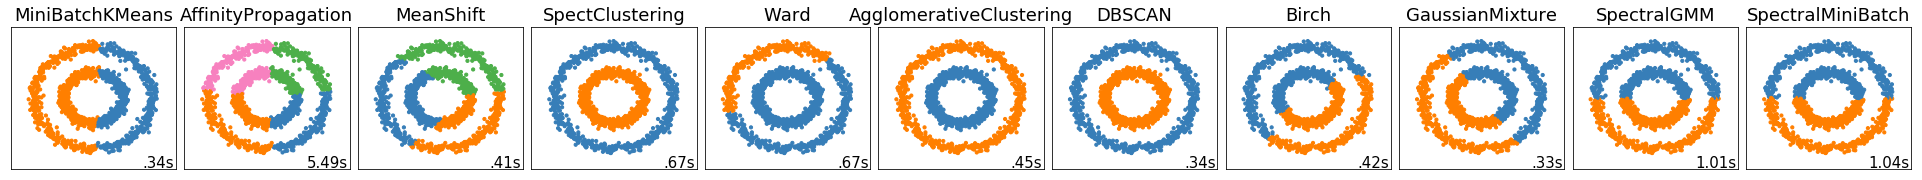

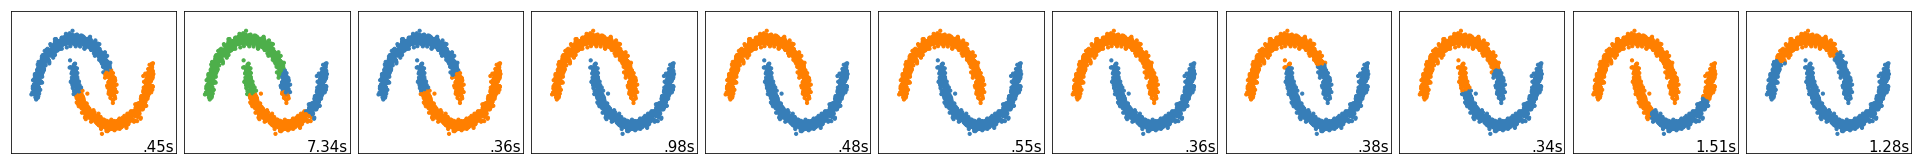

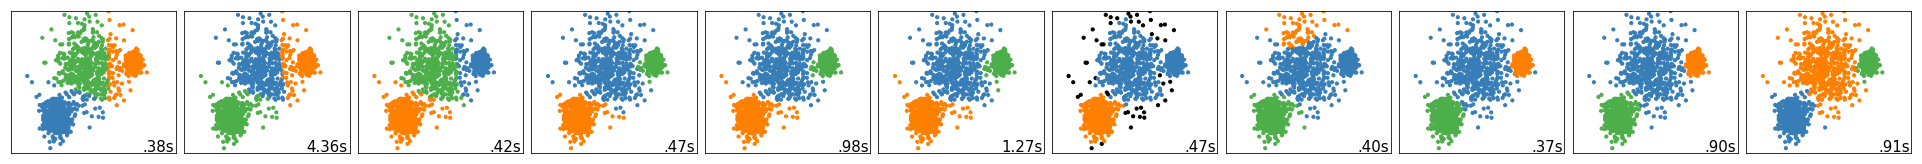

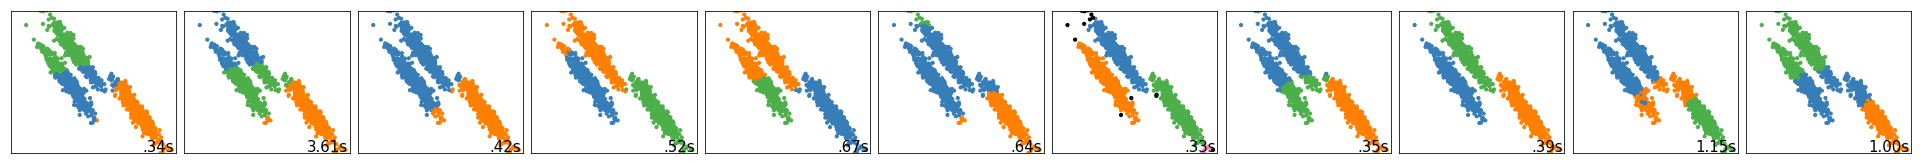

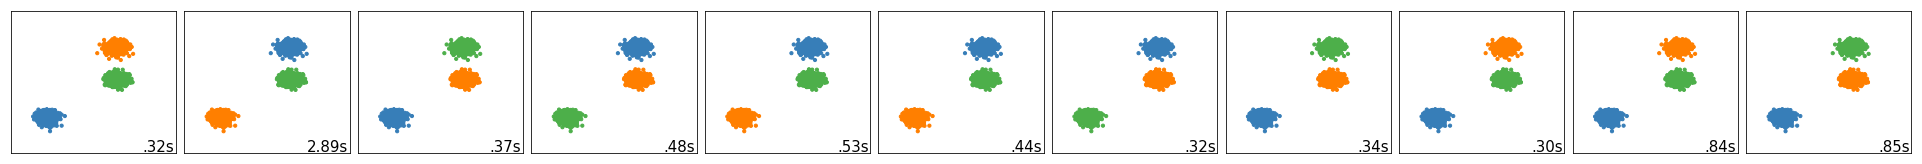

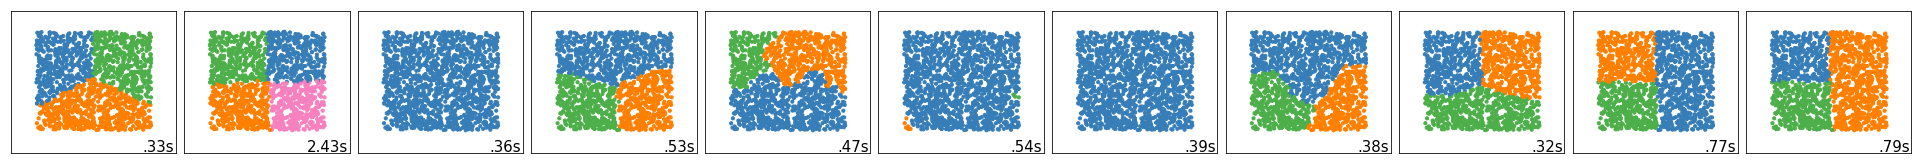

In [54]:

files = ['sampleNew0.txt','sampleNew1.txt','sampleNew2.txt','sampleNew3.txt','sampleNew4.txt','sampleNew5.txt']

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

dataset_list = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

dim = {'SpectralGMM': 2,'SpectralMiniBatch':2}

for i_dataset, (dataset, algo_params) in enumerate(dataset_list):
    
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')
    
    
    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('GaussianMixture', gmm),
        ('SpectralGMM', gmm),
        ('SpectralMiniBatch', two_means),
    )

    plotClusteredData(X, clustering_algorithms, files, dataset_list, dim)

plt.show()

### Spectral Embedding into varying dimensions
Now the following shows each dataset using varying embedding dimensions.

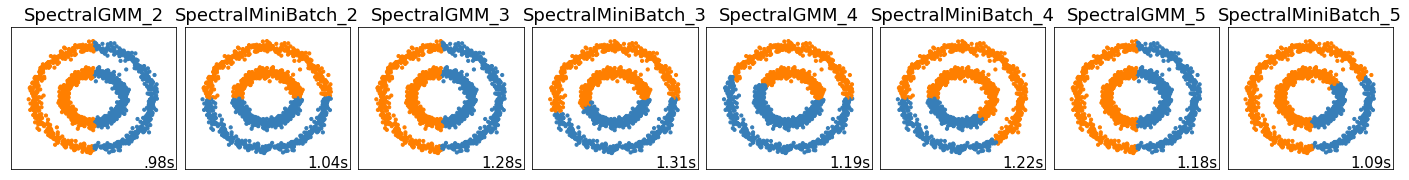

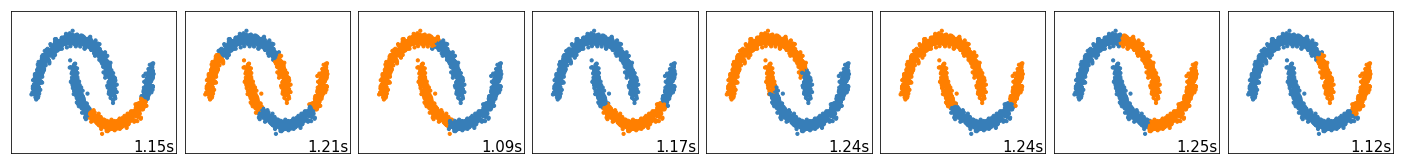

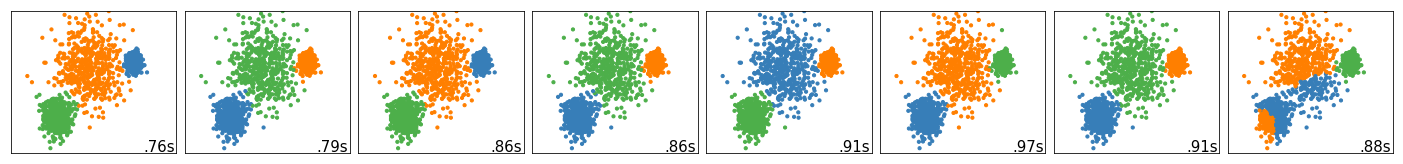

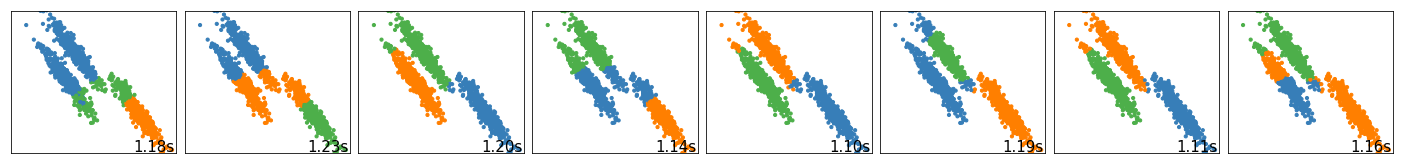

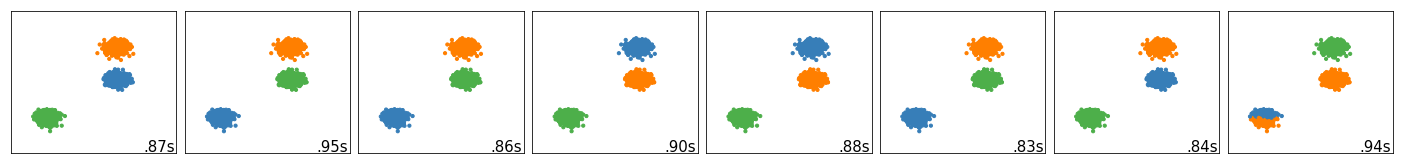

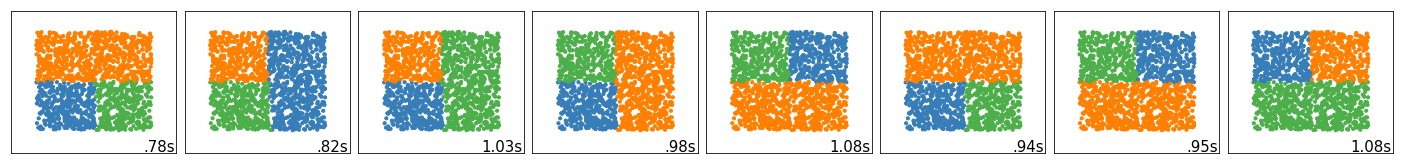

In [59]:


files = ['sampleNew0.txt','sampleNew1.txt','sampleNew2.txt','sampleNew3.txt','sampleNew4.txt','sampleNew5.txt']

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

dataset_list = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

dim = {'SpectralGMM_2':2,'SpectralMiniBatch_2':2,'SpectralGMM_3':3,'SpectralMiniBatch_3':3,'SpectralGMM_4':4,'SpectralMiniBatch_4':4,'SpectralGMM_5':5,'SpectralMiniBatch_5':5}

for i_dataset, (dataset, algo_params) in enumerate(dataset_list):
    
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # ============
    # Create cluster objects
    # ============
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('SpectralGMM_2', gmm),
        ('SpectralMiniBatch_2', two_means),
        ('SpectralGMM_3', gmm),
        ('SpectralMiniBatch_3', two_means),
        ('SpectralGMM_4', gmm),
        ('SpectralMiniBatch_4', two_means),
        ('SpectralGMM_5', gmm),
        ('SpectralMiniBatch_5', two_means),
    )
    
    plotClusteredData(X, clustering_algorithms, files, dataset_list, dim)

plt.show()

### Now to identify proper parameters for DBSCAN and Affinity Propagation with a distance/similarity matrix as input

This uses the Urerf similarity matrix as precomputed input for affinity propagation

It also uses shows the distance matrix transformation of the Urerf similarity matrix for DBSCAN 

In [63]:
valid_db = []
valid_af = []
e = .5
for i in range(-500, 500):
    dbscan = cluster.DBSCAN(eps=e, metric ='precomputed')
    af = cluster.AffinityPropagation(damping=0.9, preference = i, affinity = 'precomputed')
    # use dataset 1 #
    fname = '../input/sampleNew0.txt'
    matrix = open(fname, 'r').read()
    matrix = [item.split() for item in matrix.split('\n')[:-1]]
    X_ = np.matrix(matrix, dtype = float)
    maxElement = X_.max()
    X_Dist = 1 - (X_/maxElement)
    dbscan.fit(X_Dist)
    af.fit(X_)
    
    cluster_centers_indices = af.cluster_centers_indices_
    n_clusters_af = len(cluster_centers_indices)
    valid_af.append([i, n_clusters_af])
    
    labels = dbscan.labels_
    n_clusters_db = len(set(labels)) - (1 if -1 in labels else 0)
    valid_db.append([e, n_clusters_db])
    e += .5
i = .0000000000001
for j in range(50):
    dbscan = cluster.DBSCAN(eps=i, metric ='precomputed')
    af = cluster.AffinityPropagation(damping=0.9, preference = i, affinity = 'precomputed')
    # use dataset 1 #
    fname = '../input/sampleNew0.txt'
    matrix = open(fname, 'r').read()
    matrix = [item.split() for item in matrix.split('\n')[:-1]]
    X_ = np.matrix(matrix, dtype = float)
    maxElement = X_.max()
    X_Dist = 1 - (X_/maxElement)
    dbscan.fit(X_Dist)
    af.fit(X_)
    
    cluster_centers_indices = af.cluster_centers_indices_
    n_clusters_af = len(cluster_centers_indices)
    valid_af.append([i, n_clusters_af])
    
    labels = dbscan.labels_
    n_clusters_db = len(set(labels)) - (1 if -1 in labels else 0)
    valid_db.append([i, n_clusters_db])
        
    i = i * 2
    
i = -.0000000000001
for j in range(50):
    dbscan = cluster.DBSCAN(eps=i, metric ='precomputed')
    af = cluster.AffinityPropagation(damping=0.9, preference = i, affinity = 'precomputed')
    # use dataset 1 #
    fname = '../input/sampleNew0.txt'
    matrix = open(fname, 'r').read()
    matrix = [item.split() for item in matrix.split('\n')[:-1]]
    X_ = np.matrix(matrix, dtype = float)
    af.fit(X_)
    
    cluster_centers_indices = af.cluster_centers_indices_
    n_clusters_af = len(cluster_centers_indices)
    valid_af.append([i, n_clusters_af])
        
    i = i * 2

Text(0,0.5,'Number of Clusters')

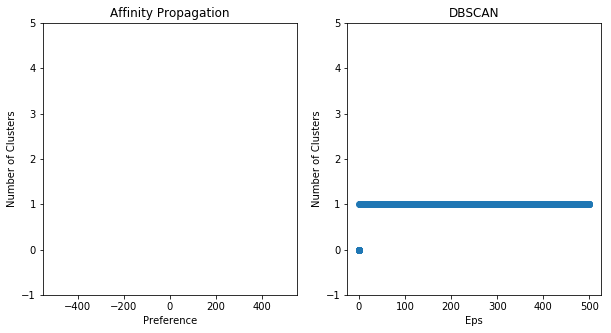

In [64]:
valid_af = np.matrix(valid_af)
valid_db = np.matrix(valid_db)
plt.figure(figsize=(5 + 5, 5))
plt.subplot(1,2,1)
plt.scatter(valid_af[:,0].tolist(),valid_af[:,1].tolist())
ax = plt.gca()
ax.set_ylim(-1,5)
plt.title("Affinity Propagation")
plt.xlabel('Preference')
plt.ylabel('Number of Clusters')
plt.subplot(1,2,2)
plt.scatter(valid_db[:,0].tolist(),valid_db[:,1].tolist())
ax = plt.gca()
ax.set_ylim(-1,5)
plt.title("DBSCAN")
plt.xlabel('Eps')
plt.ylabel('Number of Clusters')

### For a wide range of parameters, affinity propagation and dbscan fail to return between 2 and 5 clusters...

### Clustering distance and similarity matrices
The following shows DBSCAN and Agglomerative clustering on the transformed Urerf similarity matrix (distance matrix)
and affinity propagation on the Urerf similarity matrix for each dataset.

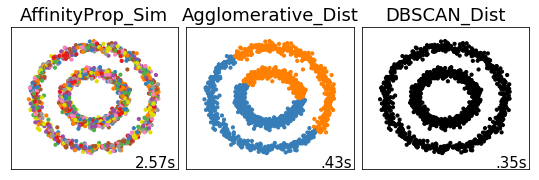

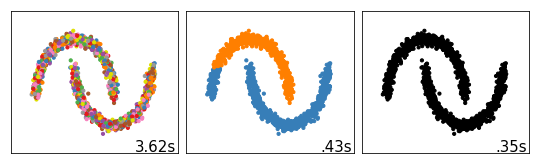

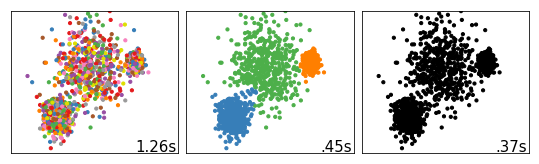

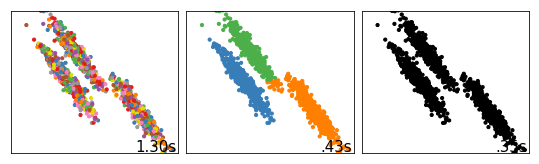

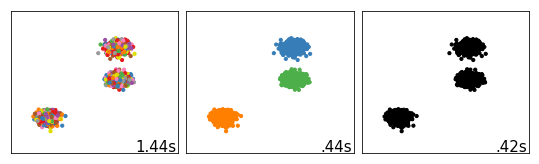

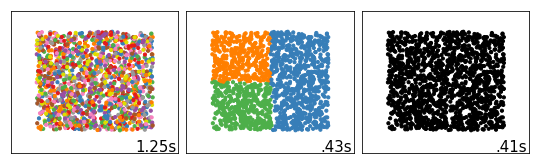

In [60]:

files = ['sampleNew0.txt','sampleNew1.txt','sampleNew2.txt','sampleNew3.txt','sampleNew4.txt','sampleNew5.txt']

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

dataset_list = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

dim = None

for i_dataset, (dataset, algo_params) in enumerate(dataset_list):
    
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    
    # ============
    # Create cluster objects
    # ============
    dbscan = cluster.DBSCAN(eps=params['eps'], metric ='precomputed')
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference = params['preference'], affinity = 'precomputed')
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity = 'precomputed',
        n_clusters=params['n_clusters'])

    clustering_algorithms = (
        ('AffinityProp_Sim', affinity_propagation),
        ('Agglomerative_Dist', average_linkage),
        ('DBSCAN_Dist', dbscan)
    )

    plotClusteredData(X, clustering_algorithms, files, dataset_list, dim)

plt.show()

### Finally, spectral embedding is used on the distance matrix transformation of Urerf's similarity matrix.

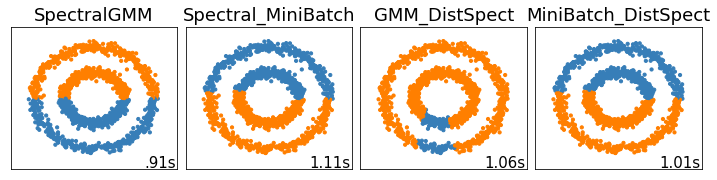

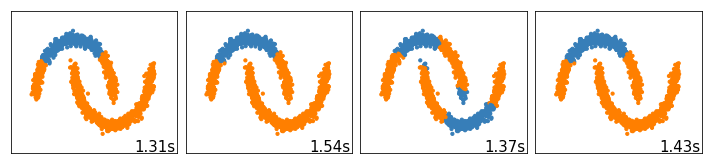

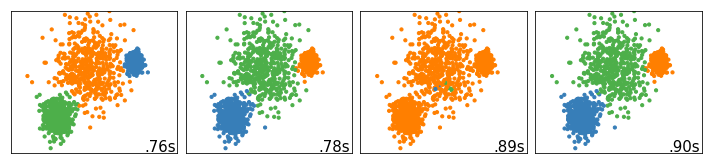

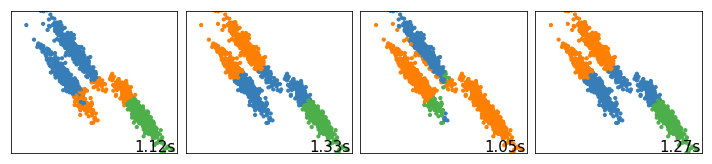

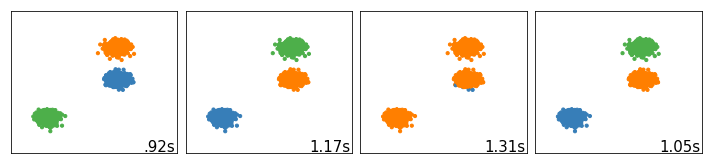

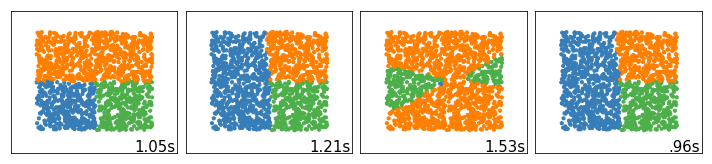

In [62]:
files = ['sampleNew0.txt','sampleNew1.txt','sampleNew2.txt','sampleNew3.txt','sampleNew4.txt','sampleNew5.txt']

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

dataset_list = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

dim = {'SpectralGMM': 2,'Spectral_MiniBatch':2,'GMM_DistSpect':2,'MiniBatch_DistSpect':2}

for i_dataset, (dataset, algo_params) in enumerate(dataset_list):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    
    # ============
    # Create cluster objects
    # ============
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('SpectralGMM', gmm),
        ('Spectral_MiniBatch', two_means),
        ('GMM_DistSpect', gmm),
        ('MiniBatch_DistSpect', two_means),
    )

    plotClusteredData(X, clustering_algorithms, files, dataset_list, dim)

plt.show()